# Baseball Testing

In [2]:
import pandas as pd
import numpy as np
import requests
from rpy2.robjects import r, pandas2ri
import pyreadr
import matplotlib.pyplot as plt
from pandasql import sqldf
from bs4 import BeautifulSoup
import requests

In [3]:
# Setting up function for loading Rdata into python from Github Source

def git_load(Name):
    github_url = f'https://github.com/cdalzell/Lahman/raw/master/data/{Name}.RData'

    # Download the RData file
    response = requests.get(github_url)
    
    with open(f'{Name}.RData', 'wb') as f:
        f.write(response.content)
    
    result = pyreadr.read_r(f'{Name}.RData')
    print(result.keys())
    
    globals()[f'{Name}_df'] = result[f'{Name}']

In [4]:
# Calling all Tables from Github
table_names = ['People','Pitching', 'AwardsPlayers', 'AwardsSharePlayers', 'PitchingPost', 'Salaries', 'AllstarFull', 'SeriesPost', 'HallOfFame']
table_names

for x in table_names:
    git_load(x)

odict_keys(['People'])
odict_keys(['Pitching'])
odict_keys(['AwardsPlayers'])
odict_keys(['AwardsSharePlayers'])
odict_keys(['PitchingPost'])
odict_keys(['Salaries'])
odict_keys(['AllstarFull'])
odict_keys(['SeriesPost'])
odict_keys(['HallOfFame'])


In [5]:
# Pitching_df Exploration
People_df.info()
print(People_df.describe())
Pitching_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20676 entries, 0 to 20675
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   playerID      20676 non-null  object  
 1   birthYear     20567 non-null  object  
 2   birthMonth    20398 non-null  object  
 3   birthDay      20256 non-null  object  
 4   birthCountry  20617 non-null  object  
 5   birthState    20136 non-null  object  
 6   birthCity     20508 non-null  object  
 7   deathYear     10098 non-null  object  
 8   deathMonth    10097 non-null  object  
 9   deathDay      10096 non-null  object  
 10  deathCountry  10094 non-null  object  
 11  deathState    10038 non-null  object  
 12  deathCity     10089 non-null  object  
 13  nameFirst     20639 non-null  object  
 14  nameLast      20676 non-null  object  
 15  nameGiven     20639 non-null  object  
 16  weight        19864 non-null  object  
 17  height        19944 non-null  object  
 18  bats  

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NA,1,2,3,3,2,...,NaN,7,NaN,0,146,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NA,12,15,30,30,30,...,NaN,7,NaN,0,1291,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NA,0,0,1,0,0,...,NaN,2,NaN,0,14,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NA,4,16,24,24,22,...,NaN,20,NaN,0,1080,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NA,0,1,1,1,1,...,NaN,0,NaN,0,57,0,21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50397,zastrro01,2022,1,NYN,NL,0,0,1,0,0,...,0,0,0,0,4,0,1,0,0,0
50398,zastrro01,2022,2,LAA,AL,0,0,5,0,0,...,0,1,0,0,12,1,3,0,0,0
50399,zerpaan01,2022,1,KCA,AL,2,1,3,2,0,...,0,1,0,0,44,0,3,0,0,1
50400,zeuchtj01,2022,1,CIN,NL,0,3,3,3,0,...,0,0,3,0,64,0,18,0,1,2


In [6]:
# Pitching_df Exploration
Pitching_df.info()
print(Pitching_df.describe())
Pitching_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50402 entries, 0 to 50401
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   playerID  50402 non-null  object  
 1   yearID    50402 non-null  int32   
 2   stint     50402 non-null  int32   
 3   teamID    50402 non-null  category
 4   lgID      50402 non-null  category
 5   W         50402 non-null  int32   
 6   L         50402 non-null  int32   
 7   G         50402 non-null  int32   
 8   GS        50402 non-null  int32   
 9   CG        50402 non-null  int32   
 10  SHO       50402 non-null  int32   
 11  SV        50402 non-null  int32   
 12  IPouts    50402 non-null  int32   
 13  H         50402 non-null  int32   
 14  ER        50402 non-null  int32   
 15  HR        50402 non-null  int32   
 16  BB        50402 non-null  int32   
 17  SO        50402 non-null  int32   
 18  BAOpp     45958 non-null  float64 
 19  ERA       50305 non-null  float64 
 20  IBB   

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NA,1,2,3,3,2,...,NaN,7,NaN,0,146,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NA,12,15,30,30,30,...,NaN,7,NaN,0,1291,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NA,0,0,1,0,0,...,NaN,2,NaN,0,14,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NA,4,16,24,24,22,...,NaN,20,NaN,0,1080,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NA,0,1,1,1,1,...,NaN,0,NaN,0,57,0,21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50397,zastrro01,2022,1,NYN,NL,0,0,1,0,0,...,0,0,0,0,4,0,1,0,0,0
50398,zastrro01,2022,2,LAA,AL,0,0,5,0,0,...,0,1,0,0,12,1,3,0,0,0
50399,zerpaan01,2022,1,KCA,AL,2,1,3,2,0,...,0,1,0,0,44,0,3,0,0,1
50400,zeuchtj01,2022,1,CIN,NL,0,3,3,3,0,...,0,0,3,0,64,0,18,0,1,2


<AxesSubplot:xlabel='yearID'>

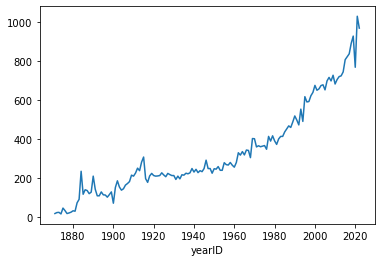

In [7]:
df = Pitching_df.groupby("yearID")['playerID'].count()
df.plot()

In [9]:
# AwardsPlayers_df Exploration
AwardsPlayers_df.info()
print(AwardsPlayers_df.describe())
AwardsPlayers_df.loc[~AwardsPlayers_df["tie"].isna()]
AwardsPlayers_df["awardID"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6531 entries, 0 to 6530
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   playerID  6531 non-null   object  
 1   awardID   6531 non-null   object  
 2   yearID    6531 non-null   int32   
 3   lgID      6527 non-null   category
 4   tie       53 non-null     object  
 5   notes     4999 non-null   object  
dtypes: category(1), int32(1), object(4)
memory usage: 236.3+ KB
            yearID
count  6531.000000
mean   1971.924208
std      32.107723
min    1877.000000
25%    1944.000000
50%    1978.000000
75%    1999.000000
max    2021.000000


array(['Pitching Triple Crown', 'Triple Crown',
       'Baseball Magazine All-Star', 'Most Valuable Player',
       'TSN All-Star', 'TSN Guide MVP',
       'TSN Major League Player of the Year', 'TSN Pitcher of the Year',
       'TSN Player of the Year', 'Rookie of the Year', 'Babe Ruth Award',
       'Lou Gehrig Memorial Award', 'World Series MVP', 'Cy Young Award',
       'Gold Glove', 'TSN Fireman of the Year', 'All-Star Game MVP',
       'Hutch Award', 'Roberto Clemente Award',
       'Rolaids Relief Man Award', 'NLCS MVP', 'ALCS MVP',
       'Silver Slugger', 'Branch Rickey Award', 'Hank Aaron Award',
       'TSN Reliever of the Year', 'Comeback Player of the Year',
       'Outstanding DH Award', 'Reliever of the Year Award',
       'SIlver Slugger'], dtype=object)

In [76]:
# AwardsPlayers_df Exploration
AwardsSharePlayers_df.info()
print(AwardsSharePlayers_df.describe())
print(AwardsSharePlayers_df['awardID'].unique())
# AwardsSharePlayers_df.loc[AwardsSharePlayers_df['yearID'] == 2012]
# AwardsSharePlayers_df.loc[AwardsSharePlayers_df['playerID'] == 'verlaju01']
AwardsSharePlayers_df.loc[(AwardsSharePlayers_df['yearID'] == 2016) & (AwardsSharePlayers_df['awardID'] == 'Rookie of the Year')]




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6879 entries, 0 to 6878
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   awardID     6879 non-null   object  
 1   yearID      6879 non-null   int32   
 2   lgID        6879 non-null   category
 3   playerID    6879 non-null   object  
 4   pointsWon   6879 non-null   float64 
 5   pointsMax   6879 non-null   int32   
 6   votesFirst  6521 non-null   float64 
dtypes: category(1), float64(2), int32(2), object(2)
memory usage: 275.7+ KB
            yearID    pointsWon    pointsMax   votesFirst
count  6879.000000  6879.000000  6879.000000  6521.000000
mean   1972.461259    43.559674   267.518389     1.624751
std      27.707848    68.265957   128.988138     4.911428
min    1911.000000     0.000000    16.000000     0.000000
25%    1950.000000     4.000000   140.000000     0.000000
50%    1975.000000    12.000000   336.000000     0.000000
75%    1996.000000    53.000000  

,awardID,yearID,lgID,playerID,pointsWon,pointsMax,votesFirst
6864,Rookie of the Year,2016,AL,fulmemi01,142.0,150,26.0
6865,Rookie of the Year,2016,AL,sanchga02,91.0,150,4.0
6866,Rookie of the Year,2016,AL,naquity01,20.0,150,0.0
6867,Rookie of the Year,2016,AL,devench02,7.0,150,0.0
6868,Rookie of the Year,2016,AL,diazed04,4.0,150,0.0
6869,Rookie of the Year,2016,AL,mazarno01,4.0,150,0.0
6870,Rookie of the Year,2016,AL,anderti01,2.0,150,0.0
6871,Rookie of the Year,2016,NL,seageco01,150.0,150,30.0
6872,Rookie of the Year,2016,NL,turnetr01,42.0,150,0.0
6873,Rookie of the Year,2016,NL,maedake01,37.0,150,0.0


In [29]:
# # LEGACY OLD Data during different attempt of webscraping BR


# # Web Scraping to get mvp points and votes for seasons after 2016
# url = 'https://www.baseball-reference.com/bullpen/2022_American_League_Most_Valuable_Player_Award'

# page = requests.get(url)

# soup = BeautifulSoup(page.text, 'html')

# table = soup.find_all('table')[0]

# mvp_table_headers = table.find_all('th')
# mvp_table_headers

# # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
# mvp_table_headers = [title.text for title in mvp_table_headers]
# # print(mvp_table_headers) # need to clean up so use .strip() to get rid of the '\n'
# df = pd.DataFrame(columns = mvp_table_headers)
# df.drop(df.columns[[3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True) # dropping all stats columns from the table.

# column_data = table.find_all('tr')

# for row in column_data[1:]: # starting at position one
#     row_data = row.find_all('td')
#     individual_row_data = [data.text.strip() for data in row_data]
#     individual_row_data = individual_row_data[:3] + individual_row_data[-10:] # only keeping the player name, team , points, and the place votes
#     length = len(df)
#     df.loc[length] = individual_row_data 

# # removing the \n in the 10th column name
# df.columns = [c.replace("\n", "") for c in df.columns] 
# df


,Player,Team,Points,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Aaron Judge,New York Yankees †,410,28,2,-,-,-,-,-,-,-,-
1,Shohei Ohtani,Los Angeles Angels,280,2,28,-,-,-,-,-,-,-,-
2,Yordan Alvarez,Houston Astros †,232,-,-,22,8,-,-,-,-,-,-
3,Jose Ramirez,Cleveland Guardians †,186,-,-,6,11,5,4,2,1,-,-
4,Jose Altuve,Houston Astros †,142,-,-,-,6,9,4,3,3,2,1
5,Andrés Giménez,Cleveland Guardians †,141,-,-,2,3,-,5,7,4,1,1
6,Julio Rodríguez,Seattle Mariners †,108,-,-,-,1,3,6,7,6,2,3
7,Mike Trout,Los Angeles Angels,90,-,-,-,-,4,4,4,6,5,2
8,Xander Bogaerts,Boston Red Sox,50,-,-,-,1,-,2,2,2,7,5
9,Justin Verlander,Houston Astros †,44,-,-,-,-,2,1,1,5,3,2


In [93]:
# Web Scraping to get mvp, CY Young, and ROY results and votes for seasons after 2016
seasons = ['2017', '2018', '2019', '2020', '2021', '2022']
mvp_tables = [0,1]
cy_tables = [2,3]
roy_tables = [4,6]



for x in seasons:
    url = f'https://www.baseball-reference.com/awards/awards_{x}.shtml'

    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')
    
    for y in mvp_tables:
        table = soup.find_all('table')[y]

        mvp_table_headers = table.find_all('th')
        mvp_table_headers

        # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
        mvp_table_headers = [title.text for title in mvp_table_headers]
        #print(mvp_table_headers) # need to clean up
        mvp_table_headers = mvp_table_headers[6:36]
        df = pd.DataFrame(columns = mvp_table_headers)

        column_data = table.find_all('tr')
        table.find_all('tr')[2]

        for row in column_data[2:]: # starting at position one
            row_data = row.find_all('td')
            individual_row_data = [data.text.strip() for data in row_data]
            length = len(df)
            df.loc[length] = individual_row_data 

        # removing the \n in the 10th column name
        df.columns = [c.replace("\n", "") for c in df.columns] 
        mvp_ = df
        globals()[f'mvp_{y}_{x}'] = df
        
#     for y in cy_tables:
#         table = soup.find_all('table')[y]

#         mvp_table_headers = table.find_all('th')
#         mvp_table_headers

#         # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
#         mvp_table_headers = [title.text for title in mvp_table_headers]
#         #print(mvp_table_headers) # need to clean up
#         mvp_table_headers = mvp_table_headers[6:36]
#         df = pd.DataFrame(columns = mvp_table_headers)

#         column_data = table.find_all('tr')
#         table.find_all('tr')[2]

#         for row in column_data[2:]: # starting at position one
#             row_data = row.find_all('td')
#             individual_row_data = [data.text.strip() for data in row_data]
#             length = len(df)
#             df.loc[length] = individual_row_data 

#         # removing the \n in the 10th column name
#         df.columns = [c.replace("\n", "") for c in df.columns] 
#         mvp_ = df
#         globals()[f'mvp_{y}_'] = df


In [94]:
mvp_0_2017

,Name,Tm,Vote Pts,1st Place,Share,WAR,G,AB,R,H,...,ERA,WHIP,G,GS,SV,IP,H,HR,BB,SO
0,José Altuve,HOU,405.0,27.0,96%,7.7,153,590,112,204,...,,,,,,,,,,
1,Aaron Judge,NYY,279.0,2.0,66%,8.0,155,542,128,154,...,,,,,,,,,,
2,José Ramírez,CLE,237.0,1.0,56%,7.0,152,585,107,186,...,,,,,,,,,,
3,Mike Trout,LAA,197.0,0.0,47%,6.9,114,402,92,123,...,,,,,,,,,,
4,Francisco Lindor,CLE,143.0,0.0,34%,5.7,159,651,99,178,...,,,,,,,,,,
5,Mookie Betts,BOS,110.0,0.0,26%,6.4,153,628,101,166,...,,,,,,,,,,
6,Corey Kluber,CLE,101.0,0.0,24%,7.9,1,2,0,1,...,2.25,0.869,29,29,0,203.2,141,21,36,265
7,Andrelton Simmons,LAA,60.0,0.0,14%,7.9,158,589,77,164,...,,,,,,,,,,
8,Chris Sale,BOS,56.0,0.0,13%,6.0,1,3,0,1,...,2.90,0.970,32,32,0,214.1,165,24,43,308
9,Nelson Cruz,SEA,44.0,0.0,10%,4.3,155,556,91,160,...,,,,,,,,,,


In [95]:
mvp_1_2019

,Name,Tm,Vote Pts,1st Place,Share,WAR,G,AB,R,H,...,ERA,WHIP,G,GS,SV,IP,H,HR,BB,SO
0,Cody Bellinger,LAD,362.0,19.0,86%,8.6,156,558,121,170,...,,,,,,,,,,
1,Christian Yelich,MIL,317.0,10.0,75%,7.0,130,489,100,161,...,,,,,,,,,,
2,Anthony Rendon,WSN,242.0,1.0,58%,7.1,146,545,117,174,...,,,,,,,,,,
3,Ketel Marte,ARI,198.0,0.0,47%,6.9,144,569,97,187,...,,,,,,,,,,
4,Ronald Acuna Jr.,ATL,155.0,0.0,37%,5.1,156,626,127,175,...,,,,,,,,,,
5,Nolan Arenado,COL,120.0,0.0,29%,7.3,155,588,102,185,...,,,,,,,,,,
6,Pete Alonso,NYM,102.0,0.0,24%,5.5,161,597,103,155,...,,,,,,,,,,
7,Freddie Freeman,ATL,90.0,0.0,21%,3.7,158,597,113,176,...,,,,,,,,,,
8,Juan Soto,WSN,45.0,0.0,11%,5.0,150,542,110,153,...,,,,,,,,,,
9,Jacob deGrom,NYM,44.0,0.0,10%,7.8,31,65,4,13,...,2.43,0.971,32,32,0,204.0,154,19,44,255


In [36]:
# PitchingPost_df Exploration
PitchingPost_df.info()
PitchingPost_df.describe()
PitchingPost_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6538 entries, 0 to 6537
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   playerID  6538 non-null   object  
 1   yearID    6538 non-null   int32   
 2   round     6538 non-null   object  
 3   teamID    6538 non-null   category
 4   lgID      6538 non-null   category
 5   W         6538 non-null   int32   
 6   L         6538 non-null   int32   
 7   G         6538 non-null   int32   
 8   GS        6538 non-null   int32   
 9   CG        6538 non-null   int32   
 10  SHO       6538 non-null   int32   
 11  SV        6538 non-null   int32   
 12  IPouts    6538 non-null   int32   
 13  H         6538 non-null   int32   
 14  ER        6538 non-null   int32   
 15  HR        6538 non-null   int32   
 16  BB        6538 non-null   int32   
 17  SO        6538 non-null   int32   
 18  BAOpp     6466 non-null   float64 
 19  ERA       6503 non-null   float64 
 20  IBB     

,playerID,yearID,round,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,becanbu01,1884,WS,NY4,AA,0,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,0,12,NaN,NaN,NaN
1,keefeti01,1884,WS,NY4,AA,0,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,0,9,NaN,NaN,NaN
2,radboch01,1884,WS,PRO,NL,3,0,3,3,3,...,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN
3,carutbo01,1885,WS,SL4,AA,1,1,3,3,3,...,NaN,NaN,NaN,NaN,NaN,0,18,NaN,NaN,NaN
4,clarkjo01,1885,WS,CHN,NL,0,1,2,2,2,...,NaN,NaN,NaN,NaN,NaN,0,14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6533,wheelza01,2022,WS,PHI,NL,0,2,2,2,0,...,0,0,1,0,44,0,7,0,0,2
6534,wilsost02,2022,NLCS,SDN,NL,0,0,1,0,0,...,0,0,0,0,4,0,1,0,0,0
6535,wilsost02,2022,NLDS2,SDN,NL,0,0,2,0,0,...,0,1,1,0,11,0,1,0,1,0
6536,wilsost02,2022,NLWC1,SDN,NL,0,0,1,0,0,...,0,0,0,0,3,1,0,0,0,0


In [45]:
# PitchingPost_df Exploration
Salaries_df.info()
print(Salaries_df.describe())
Salaries_df.loc[Salaries_df["playerID"] == "strasst01"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26428 entries, 0 to 26427
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   yearID    26428 non-null  int32   
 1   teamID    26428 non-null  category
 2   lgID      26428 non-null  category
 3   playerID  26428 non-null  object  
 4   salary    26428 non-null  int32   
dtypes: category(2), int32(2), object(1)
memory usage: 466.1+ KB
             yearID        salary
count  26428.000000  2.642800e+04
mean    2000.878727  2.085634e+06
std        8.909314  3.455348e+06
min     1985.000000  0.000000e+00
25%     1994.000000  2.947020e+05
50%     2001.000000  5.500000e+05
75%     2009.000000  2.350000e+06
max     2016.000000  3.300000e+07


,yearID,teamID,lgID,playerID,salary
22288,2011,WAS,NL,strasst01,4375000
23135,2012,WAS,NL,strasst01,4875000
23950,2013,WAS,NL,strasst01,3900000
24754,2014,WAS,NL,strasst01,3975000
25567,2015,WAS,NL,strasst01,7400000
26423,2016,WAS,NL,strasst01,10400000


<AxesSubplot:xlabel='yearID'>

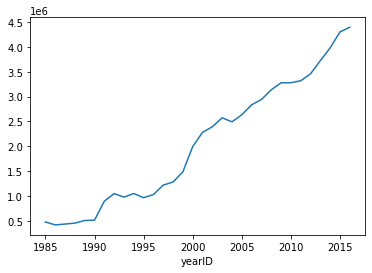

In [64]:
# Salaries were trackin started in 1985
df = Salaries_df.groupby("yearID")['salary'].mean()
df.plot()

In [48]:
# PitchingPost_df Exploration
AllstarFull_df.info()
print(AllstarFull_df.describe())
AllstarFull_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5516 entries, 0 to 5515
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   playerID     5516 non-null   object  
 1   yearID       5516 non-null   int32   
 2   gameNum      5516 non-null   int32   
 3   gameID       5467 non-null   object  
 4   teamID       5516 non-null   category
 5   lgID         5516 non-null   category
 6   GP           5516 non-null   int32   
 7   startingPos  1731 non-null   object  
dtypes: category(2), int32(3), object(3)
memory usage: 206.3+ KB
            yearID      gameNum           GP
count  5516.000000  5516.000000  5516.000000
mean   1979.730421     0.094996     0.782088
std      25.462361     0.389393     0.412864
min    1933.000000     0.000000     0.000000
25%    1959.000000     0.000000     1.000000
50%    1980.000000     0.000000     1.000000
75%    2003.000000     0.000000     1.000000
max    2022.000000     2.000000     1.0

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,gomezle01,1933,0,ALS193307060,NYA,AL,1,1
1,ferreri01,1933,0,ALS193307060,BOS,AL,1,2
2,gehrilo01,1933,0,ALS193307060,NYA,AL,1,3
3,gehrich01,1933,0,ALS193307060,DET,AL,1,4
4,dykesji01,1933,0,ALS193307060,CHA,AL,1,5
...,...,...,...,...,...,...,...,...
5511,rileyau01,2022,0,NLS202207190,ATL,NL,1,NaN
5512,schwaky01,2022,0,NLS202207190,PHI,NL,1,NaN
5513,sotoju01,2022,0,NLS202207190,WAS,NL,1,NaN
5514,swansda01,2022,0,NLS202207190,ATL,NL,1,NaN


In [50]:
# SeriesPost_df Exploration
SeriesPost_df.info()
print(SeriesPost_df.describe())
SeriesPost_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   yearID        378 non-null    int32   
 1   round         378 non-null    object  
 2   teamIDwinner  378 non-null    category
 3   lgIDwinner    378 non-null    category
 4   teamIDloser   378 non-null    category
 5   lgIDloser     378 non-null    category
 6   wins          378 non-null    int32   
 7   losses        378 non-null    int32   
 8   ties          378 non-null    int32   
dtypes: category(4), int32(4), object(1)
memory usage: 13.5+ KB
            yearID        wins      losses        ties
count   378.000000  378.000000  378.000000  378.000000
mean   1988.473545    3.433862    1.341270    0.007937
std      32.956938    0.875312    1.103378    0.088850
min    1884.000000    1.000000    0.000000    0.000000
25%    1976.000000    3.000000    0.000000    0.000000
50%    2000.000000

,yearID,round,teamIDwinner,lgIDwinner,teamIDloser,lgIDloser,wins,losses,ties
0,1884,WS,PRO,NL,NY4,AA,3,0,0
1,1885,WS,CHN,NL,SL4,AA,3,3,1
2,1886,WS,SL4,AA,CHN,NL,4,2,0
3,1887,WS,DTN,NL,SL4,AA,10,5,0
4,1888,WS,NY1,NL,SL4,AA,6,4,0
...,...,...,...,...,...,...,...,...,...
373,2022,NLWC2,PHI,NL,SLN,NL,2,0,0
374,2022,NLDS1,PHI,NL,ATL,NL,3,1,0
375,2022,NLDS2,SDN,NL,LAN,NL,3,1,0
376,2022,NLCS,PHI,NL,SDN,NL,4,1,0


In [69]:
# HallOfFame_df Exploration
HallOfFame_df.info()
print(HallOfFame_df.describe())
HallOfFame_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   playerID     4323 non-null   object  
 1   yearID       4323 non-null   int32   
 2   votedBy      4323 non-null   object  
 3   ballots      4116 non-null   float64 
 4   needed       3959 non-null   float64 
 5   votes        4116 non-null   float64 
 6   inducted     4323 non-null   category
 7   category     4323 non-null   category
 8   needed_note  157 non-null    object  
dtypes: category(2), float64(3), int32(1), object(3)
memory usage: 228.4+ KB
            yearID      ballots       needed        votes
count  4323.000000  4116.000000  3959.000000  4116.000000
mean   1971.262318   325.021380   247.208133    53.114431
std      24.782481   124.205544    93.429518    87.158114
min    1936.000000    78.000000    59.000000     0.000000
25%    1950.000000   233.000000   176.000000     2.000

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN
...,...,...,...,...,...,...,...,...,...
4318,hodgegi01,2022,Veterans,NaN,NaN,NaN,Y,Player,NaN
4319,kaatji01,2022,Veterans,NaN,NaN,NaN,Y,Player,NaN
4320,minosmi01,2022,Veterans,NaN,NaN,NaN,Y,Player,NaN
4321,oneilbu01,2022,Veterans,NaN,NaN,NaN,Y,Pioneer/Executive,NaN


In [82]:
# Pitching_df and hall of fame
q = '''
SELECT 
p.playerID,
MAX(Year_ID)
FROM
    Pitching_df p
INNER JOIN
    HallOfFame_df h
        on p.playerID = h.playerID
WHERE
h.inducted = 'Y';
'''
joined = sqldf(q, locals())
joined

p = '''
SELECT 
playerID,
MAX(yearID)
FROM
    Pitching_df 
GROUP BY playerID;
'''
joined = sqldf(p, locals())
joined



,playerID,MAX(yearID)
0,aardsda01,2015
1,aasedo01,1990
2,abadfe01,2021
3,abbeybe01,1896
4,abbeych01,1896
...,...,...
10379,zuberbi01,1947
10380,zuberty01,2021
10381,zumayjo01,2010
10382,zuverge01,1959


In [92]:
# Pitching_df and hall of fame
q = '''
SELECT 
*
FROM
    (SELECT 
        playerID,
        MAX(yearID) as yearID
    FROM
    Pitching_df 
    GROUP BY playerID) p

INNER JOIN
    HallOfFame_df h
        on p.playerID = h.playerID
WHERE
h.inducted = 'Y'
AND p.yearID >= 1985
order by 2;
'''
joined = sqldf(q, locals())
joined


,playerID,yearID,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,fingero01,1985,fingero01,1992,BBWAA,430.0,323.0,349.0,Y,Player,None
1,seaveto01,1986,seaveto01,1992,BBWAA,430.0,323.0,425.0,Y,Player,None
2,niekrph01,1987,niekrph01,1997,BBWAA,473.0,353.0,380.0,Y,Player,None
3,carltst01,1988,carltst01,1994,BBWAA,456.0,342.0,436.0,Y,Player,None
4,suttodo01,1988,suttodo01,1998,BBWAA,473.0,355.0,386.0,Y,Player,None
5,suttebr01,1988,suttebr01,2006,BBWAA,520.0,390.0,400.0,Y,Player,None
6,blylebe01,1992,blylebe01,2011,BBWAA,581.0,436.0,463.0,Y,Player,None
7,ryanno01,1993,ryanno01,1999,BBWAA,497.0,373.0,491.0,Y,Player,None
8,gossari01,1994,gossari01,2008,BBWAA,543.0,408.0,466.0,Y,Player,None
9,morrija02,1994,morrija02,2018,Veterans,NaN,NaN,NaN,Y,Player,None


In [175]:
# Pitching_df and Allstar count for each player.
q = '''
SELECT
    p.playerID,
    count(a.yearID) as AllStarAppearances
FROM
    Pitching_df p
LEFT JOIN
    AllstarFull_df a
        on p.playerID = a.playerID
        and p.yearID = a.yearID
GROUP BY p.playerID
ORDER BY 2
;
'''
AllStarAppearances = sqldf(q, locals())
AllStarAppearances

,playerID,AllStarAppearances
0,aardsda01,0
1,abadfe01,0
2,abbeybe01,0
3,abbeych01,0
4,abbotco01,0
...,...,...
10379,maricju01,10
10380,clemero02,11
10381,riverma01,13
10382,seaveto01,13


In [180]:
# Individual Award counts for each player
q = '''
SELECT
p.playerID,
a.awardID,
count(a.yearID) as AwardCount
FROM
    Pitching_df p
LEFT JOIN
    AwardsPlayers_df a
        on p.playerID = a.playerID
        and p.yearID = a.yearID
GROUP BY 1, 2 
;
'''
IndividAwards = sqldf(q, locals())
IndividAwards
pivot_IndividAwards = IndividAwards.pivot(index='playerID', columns='awardID', values='AwardCount').fillna(0)
pivot_IndividAwards.reset_index(inplace=True)
pivot_IndividAwards.columns.name = None
IndividAwards = pivot_IndividAwards
IndividAwards.drop(IndividAwards.columns[[1]], axis=1, inplace=True)
IndividAwards

# Total Award counts for each player
q = '''
SELECT
playerID,
SUM(AwardCount) as TotalAwards
FROM
(SELECT
p.playerID,
a.awardID,
count(a.yearID) as AwardCount
FROM
    Pitching_df p
LEFT JOIN
    AwardsPlayers_df a
        on p.playerID = a.playerID
        and p.yearID = a.yearID
GROUP BY 1, 2
)
GROUP BY 1
;
'''
TotalAwards = sqldf(q, locals())
TotalAwards

# Joining individual and total award counts for each player
q = '''
SELECT
i.*,
t.TotalAwards
FROM
    IndividAwards i
INNER JOIN
    TotalAwards t
        on i.playerID = t.playerID
;
'''
Awards = sqldf(q, locals())
Awards

,playerID,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hutch Award,...,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Reliever of the Year,World Series MVP,TotalAwards
0,aardsda01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,aasedo01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,abadfe01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,abbeybe01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,abbeych01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10379,zuberbi01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10380,zuberty01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10381,zumayjo01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10382,zuverge01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
